In [ ]:
import math
import heapq
from typing import Dict, List, Tuple, Set, Optional, Union
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import Normalize
import datetime
import time
import threading  # 新增导入
import random  # 新增导入

# 地球半径（米），用于计算经纬度之间的距离
EARTH_RADIUS = 6371000

# 游船相关参数
BOAT_SPEED = 5.0  # 游船速度，单位：米/秒 (约18公里/小时)
BOAT_SCHEDULE_START = 8  # 游船开始时间（小时）
BOAT_SCHEDULE_END = 16   # 游船结束时间（小时）
BOAT_WAIT_TIME = 600     # 游船等待时间，单位：秒 (10分钟)
BOAT_INTERVAL = 3600     # 游船发车间隔，单位：秒 (1小时)

# 观光车相关参数
TOUR_BUS_SPEED = 10.0  # 观光车速度，单位：米/秒 (约36公里/小时)
TOUR_BUS_COUNT = 10    # 观光车数量
TOUR_BUS_START_HOUR = 8  # 观光车开始时间（小时）
TOUR_BUS_END_HOUR = 16   # 观光车结束时间（小时）
TOUR_BUS_STOP_TIME = 180  # 观光车停靠时间，单位：秒 (3分钟)
TOUR_BUS_BASE_FARE = 5    # 观光车基础票价
TOUR_BUS_PER_STOP_FARE = 3  # 观光车每站附加票价

# 观光车路线定义
TOUR_BUS_ROUTES = [
    # 路线1: 入口 -> 花园 -> 湖泊 -> 观景台 -> 餐厅 -> 博物馆 -> 出口 -> 返回
    ["入口", "花园", "湖泊", "观景台", "餐厅", "博物馆", "出口"],
    # 路线2: 入口 -> 花园 -> 观景台 -> 博物馆 -> 出口 -> 返回
    ["入口", "花园", "观景台", "博物馆", "出口"]
]

# 全局变量，存储观光车当前位置
tour_bus_positions = []
tour_bus_lock = threading.Lock()

In [48]:
class Node:
    """节点类，表示景点或道路转弯点"""
    def __init__(self, node_id: str, lat: float, lon: float, is_attraction: bool = False):
        self.id = node_id
        self.lat = lat
        self.lon = lon
        self.is_attraction = is_attraction  # 是否为景点（而非道路转弯点）
    
    def __str__(self):
        return f"Node({self.id}, {self.lat}, {self.lon}, {self.is_attraction})"

In [49]:
class Road:
    """道路类，表示两个节点之间的连接"""
    def __init__(self, road_id: str, node1_id: str, node2_id: str, 
                 length: float, density: float = 0.0, is_blocked: bool = False):
        self.id = road_id
        self.node1_id = node1_id
        self.node2_id = node2_id
        self.length = length  # 道路长度（米）
        self.density = density  # 游客密度（0-1之间的值）
        self.is_blocked = is_blocked  # 是否被湖水隔开
    
    def __str__(self):
        return f"Road({self.id}, {self.node1_id}-{self.node2_id}, {self.length}m, density: {self.density}, blocked: {self.is_blocked})"

In [50]:
class ScenicAreaGraph:
    """景区图类，包含所有节点和道路"""
    def __init__(self):
        self.nodes: Dict[str, Node] = {}  # 节点ID到节点的映射
        self.roads: Dict[str, Road] = {}  # 道路ID到道路的映射
        self.adjacency_list: Dict[str, List[Tuple[str, str]]] = {}  # 邻接表：节点ID -> [(相邻节点ID, 道路ID)]
    
    def add_node(self, node: Node):
        """添加节点"""
        self.nodes[node.id] = node
        if node.id not in self.adjacency_list:
            self.adjacency_list[node.id] = []
    
    def add_road(self, road: Road):
        """添加道路"""
        self.roads[road.id] = road
        
        # 更新邻接表
        if road.node1_id in self.adjacency_list and road.node2_id in self.nodes:
            self.adjacency_list[road.node1_id].append((road.node2_id, road.id))
        
        if road.node2_id in self.adjacency_list and road.node1_id in self.nodes:
            self.adjacency_list[road.node2_id].append((road.node1_id, road.id))
    
    def get_neighbors(self, node_id: str) -> List[Tuple[str, str]]:
        """获取节点的所有邻居节点及连接的道路ID"""
        return self.adjacency_list.get(node_id, [])
    
    def get_road(self, road_id: str) -> Optional[Road]:
        """根据道路ID获取道路"""
        return self.roads.get(road_id)
    
    def get_node(self, node_id: str) -> Optional[Node]:
        """根据节点ID获取节点"""
        return self.nodes.get(node_id)

In [51]:
def get_next_boat_time(current_time: datetime.datetime = None) -> Tuple[datetime.datetime, int]:
    """
    获取下一班游船的时间和等待时间
    
    参数:
        current_time: 当前时间，如果为None则使用系统当前时间
    
    返回:
        (下一班游船时间, 需要等待的秒数)
        如果当前时间已超过最后一班船，返回(None, -1)
    """
    if current_time is None:
        current_time = datetime.datetime.now()
    
    # 获取今天的日期
    today = current_time.date()
    
    # 创建游船时间表
    boat_times = []
    for hour in range(BOAT_SCHEDULE_START, BOAT_SCHEDULE_END + 1):
        boat_time = datetime.datetime.combine(today, datetime.time(hour, 0))
        boat_times.append(boat_time)
    
    # 找到下一班船
    for boat_time in boat_times:
        # 船会等待10分钟
        departure_time = boat_time + datetime.timedelta(seconds=BOAT_WAIT_TIME)
        
        # 如果当前时间在船到达和离开之间
        if current_time < departure_time:
            wait_time = max(0, (boat_time - current_time).total_seconds())
            return boat_time, wait_time
    
    # 如果所有船都已离开
    return None, -1

In [52]:
def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """计算两个经纬度坐标之间的哈弗辛距离（米）"""
    # 将角度转换为弧度
    phi1 = math.radians(lat1)
    phi2 = math.radians(lat2)
    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)
    
    # 哈弗辛公式
    a = math.sin(delta_phi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta_lambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    
    return EARTH_RADIUS * c

In [53]:
def calculate_speed(density: float, base_speed: float = 1.4) -> float:
    """
    根据游客密度计算实际步行速度
    
    参数:
        density: 游客密度 (0-1)
        base_speed: 基础步行速度 (米/秒)，默认1.4m/s (约5公里/小时)
    
    返回:
        实际步行速度 (米/秒)
    """
    # 简单模型：密度越高，速度越慢
    # 当密度为0时，速度为base_speed
    # 当密度为1时，速度降低为base_speed的0.3倍
    return base_speed * (1 - 0.7 * density)

In [54]:
def heuristic(graph: ScenicAreaGraph, node1_id: str, node2_id: str, cost_type: str) -> float:
    """
    启发式函数：估计从节点1到节点2的代价
    
    参数:
        graph: 景区图
        node1_id: 起始节点ID
        node2_id: 目标节点ID
        cost_type: 代价类型，"distance"或"time"
    
    返回:
        估计代价
    """
    node1 = graph.get_node(node1_id)
    node2 = graph.get_node(node2_id)
    
    if not node1 or not node2:
        return float('inf')
    
    # 计算直线距离
    distance = haversine_distance(node1.lat, node1.lon, node2.lat, node2.lon)
    
    if cost_type == "distance":
        return distance
    else:  # time
        # 使用最大速度（密度为0时的速度）来估计时间
        max_speed = calculate_speed(0)
        return distance / max_speed if max_speed > 0 else float('inf')

In [55]:
def reconstruct_path(came_from: Dict[str, Tuple[str, str]], current_id: str) -> List[str]:
    """
    从came_from字典重构路径
    
    参数:
        came_from: 记录每个节点的前驱节点和道路的字典
        current_id: 终点节点ID
    
    返回:
        路径节点ID列表
    """
    path = [current_id]
    while current_id in came_from:
        current_id, _ = came_from[current_id]
        path.append(current_id)
    path.reverse()
    return path

In [56]:
def a_star(graph: ScenicAreaGraph, start_id: str, end_id: str, cost_type: str = "time", 
          start_time: datetime.datetime = None) -> Tuple[List[str], float, List[Tuple[str, datetime.datetime]]]:
    """
    A*算法实现
    
    参数:
        graph: 景区图
        start_id: 起点节点ID
        end_id: 终点节点ID
        cost_type: 代价类型，"distance"或"time"
        start_time: 出发时间，仅对cost_type="time"有效
    
    返回:
        (路径节点ID列表, 总代价, 游船信息列表) 或 ([], float('inf'), []) 如果找不到路径
        游船信息格式: (道路ID, 乘船时间)
    """
    # 验证起点和终点是否为景点
    start_node = graph.get_node(start_id)
    end_node = graph.get_node(end_id)
    if not start_node or not end_node or not start_node.is_attraction or not end_node.is_attraction:
        return [], float('inf'), []
    
    # 对于最短路径，不需要考虑时间
    if cost_type == "distance":
        # 开放列表：存储待探索的节点 (f_score, node_id)
        open_set = []
        heapq.heappush(open_set, (0, start_id))
        
        # 从起点到每个节点的实际代价
        g_score = {start_id: 0}
        
        # 从起点经过每个节点到终点的估计代价
        f_score = {start_id: heuristic(graph, start_id, end_id, cost_type)}
        
        # 记录路径
        came_from = {}
        
        while open_set:
            # 获取f_score最小的节点
            current_f, current_id = heapq.heappop(open_set)
            
            # 如果到达终点，重构路径
            if current_id == end_id:
                path = reconstruct_path(came_from, current_id)
                total_cost = g_score[current_id]
                return path, total_cost, []
            
            # 探索当前节点的所有邻居
            for neighbor_id, road_id in graph.get_neighbors(current_id):
                road = graph.get_road(road_id)
                if not road:
                    continue
                
                # 计算从当前节点到邻居节点的代价
                if cost_type == "distance":
                    cost = road.length
                else:  # time
                    speed = calculate_speed(road.density)
                    cost = road.length / speed if speed > 0 else float('inf')
                
                # 计算从起点到邻居节点的总代价
                tentative_g_score = g_score.get(current_id, float('inf')) + cost
                
                # 如果找到更优路径，更新信息
                if tentative_g_score < g_score.get(neighbor_id, float('inf')):
                    came_from[neighbor_id] = (current_id, road_id)
                    g_score[neighbor_id] = tentative_g_score
                    f_score[neighbor_id] = tentative_g_score + heuristic(graph, neighbor_id, end_id, cost_type)
                    
                    # 如果邻居节点不在开放列表中，加入开放列表
                    if neighbor_id not in [node_id for _, node_id in open_set]:
                        heapq.heappush(open_set, (f_score[neighbor_id], neighbor_id))
        
        return [], float('inf'), []
    
    else:  # 最快路径，考虑游船
        # 设置出发时间
        if start_time is None:
            start_time = datetime.datetime.now()
        
        # 开放列表：存储待探索的节点 (f_score, node_id, current_time, boat_info)
        open_set = []
        heapq.heappush(open_set, (0, start_id, start_time, []))
        
        # 从起点到每个节点的实际代价
        g_score = {start_id: 0}
        
        # 从起点经过每个节点到终点的估计代价
        f_score = {start_id: heuristic(graph, start_id, end_id, cost_type)}
        
        # 记录路径和到达时间
        came_from = {}
        arrival_time = {start_id: start_time}
        
        while open_set:
            # 获取f_score最小的节点
            current_f, current_id, current_time, current_boat_info = heapq.heappop(open_set)
            
            # 如果到达终点，重构路径
            if current_id == end_id:
                path = reconstruct_path(came_from, current_id)
                total_time = (current_time - start_time).total_seconds()
                return path, total_time, current_boat_info
            
            # 探索当前节点的所有邻居
            for neighbor_id, road_id in graph.get_neighbors(current_id):
                road = graph.get_road(road_id)
                if not road:
                    continue
                
                # 计算从当前节点到邻居节点的代价
                if road.is_blocked:
                    # 处理游船道路
                    next_boat_time, wait_time = get_next_boat_time(current_time)
                    
                    # 如果没有船了，跳过这条路
                    if next_boat_time is None:
                        continue
                    
                    # 计算航行时间
                    sail_time = road.length / BOAT_SPEED
                    
                    # 总时间 = 等待时间 + 航行时间
                    cost = wait_time + sail_time
                    
                    # 到达邻居节点的时间
                    neighbor_time = current_time + datetime.timedelta(seconds=cost)
                    
                    # 更新游船信息
                    new_boat_info = current_boat_info + [(road_id, next_boat_time)]
                else:
                    # 普通道路
                    speed = calculate_speed(road.density)
                    cost = road.length / speed if speed > 0 else float('inf')
                    
                    # 到达邻居节点的时间
                    neighbor_time = current_time + datetime.timedelta(seconds=cost)
                    
                    # 游船信息不变
                    new_boat_info = current_boat_info
                
                # 计算从起点到邻居节点的总代价
                tentative_g_score = g_score.get(current_id, float('inf')) + cost
                
                # 如果找到更优路径，更新信息
                if tentative_g_score < g_score.get(neighbor_id, float('inf')):
                    came_from[neighbor_id] = (current_id, road_id)
                    g_score[neighbor_id] = tentative_g_score
                    arrival_time[neighbor_id] = neighbor_time
                    f_score[neighbor_id] = tentative_g_score + heuristic(graph, neighbor_id, end_id, cost_type)
                    
                    # 如果邻居节点不在开放列表中，加入开放列表
                    found = False
                    for i, (f, nid, t, bi) in enumerate(open_set):
                        if nid == neighbor_id:
                            found = True
                            if tentative_g_score < g_score.get(neighbor_id, float('inf')):
                                open_set[i] = (f_score[neighbor_id], neighbor_id, neighbor_time, new_boat_info)
                                heapq.heapify(open_set)
                            break
                    
                    if not found:
                        heapq.heappush(open_set, (f_score[neighbor_id], neighbor_id, neighbor_time, new_boat_info))
        
        return [], float('inf'), []

In [57]:
def a_star_shortest_path(graph: ScenicAreaGraph, start_id: str, end_id: str) -> Tuple[List[str], float]:
    """
    使用A*算法寻找最短路径（基于距离）
    
    参数:
        graph: 景区图
        start_id: 起点节点ID
        end_id: 终点节点ID
    
    返回:
        (路径节点ID列表, 总距离) 或 ([], float('inf')) 如果找不到路径
    """
    return a_star(graph, start_id, end_id, cost_type="distance")

def a_star_fastest_path(graph: ScenicAreaGraph, start_id: str, end_id: str, 
                       start_time: datetime.datetime = None) -> Tuple[List[str], float, List[Tuple[str, datetime.datetime]]]:
    """
    使用A*算法寻找最快路径（基于时间，考虑游客密度影响和游船）
    
    参数:
        graph: 景区图
        start_id: 起点节点ID
        end_id: 终点节点ID
        start_time: 出发时间，如果为None则使用当前时间
    
    返回:
        (路径节点ID列表, 总时间, 游船信息列表) 或 ([], float('inf'), []) 如果找不到路径
        游船信息格式: (道路ID, 乘船时间)
    """
    return a_star(graph, start_id, end_id, cost_type="time", start_time=start_time)

In [58]:
def print_path(graph: ScenicAreaGraph, path: List[str], total_cost: float, cost_type: str, 
              boat_info: List[Tuple[str, datetime.datetime]] = None):
    """
    打印路径详情
    
    参数:
        graph: 景区图
        path: 路径节点ID列表
        total_cost: 总代价
        cost_type: 代价类型，"distance"或"time"
        boat_info: 游船信息列表
    """
    if not path:
        print("无法找到路径")
        return
    
    print(f"路径找到! 总{'距离' if cost_type == 'distance' else '时间'}: {total_cost:.2f}{'米' if cost_type == 'distance' else '秒'}")
    
    # 打印游船信息
    if boat_info:
        print("游船信息:")
        for road_id, boat_time in boat_info:
            road = graph.get_road(road_id)
            if road:
                print(f"  乘坐游船通过道路 {road_id} ({road.node1_id}-{road.node2_id}), 发船时间: {boat_time.strftime('%H:%M:%S')}")
    
    print("路径详情:")
    
    for i in range(len(path) - 1):
        node1_id = path[i]
        node2_id = path[i + 1]
        
        # 查找连接两个节点的道路
        road = None
        for neighbor_id, road_id in graph.get_neighbors(node1_id):
            if neighbor_id == node2_id:
                road = graph.get_road(road_id)
                break
        
        if road:
            node1 = graph.get_node(node1_id)
            node2 = graph.get_node(node2_id)
            is_attraction1 = "景点" if node1.is_attraction else "转弯点"
            is_attraction2 = "景点" if node2.is_attraction else "转弯点"
            
            if cost_type == "distance":
                print(f"  {node1_id} ({is_attraction1}) -> {node2_id} ({is_attraction2}): {road.length:.2f}米")
            else:
                if road.is_blocked:
                    print(f"  {node1_id} ({is_attraction1}) -> {node2_id} ({is_attraction2}): 乘船 {road.length:.2f}米 (船速: {BOAT_SPEED:.2f}米/秒)")
                else:
                    speed = calculate_speed(road.density)
                    time_cost = road.length / speed if speed > 0 else float('inf')
                    print(f"  {node1_id} ({is_attraction1}) -> {node2_id} ({is_attraction2}): {time_cost:.2f}秒 (密度: {road.density:.2f}, 速度: {speed:.2f}米/秒)")

In [59]:
def visualize_graph(graph: ScenicAreaGraph, shortest_path: List[str] = None, fastest_path: List[str] = None):
    """
    可视化景区图和路径
    
    参数:
        graph: 景区图
        shortest_path: 最短路径节点ID列表
        fastest_path: 最快路径节点ID列表
    """
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # 绘制所有道路
    for road_id, road in graph.roads.items():
        node1 = graph.get_node(road.node1_id)
        node2 = graph.get_node(road.node2_id)
        
        if node1 and node2:
            # 根据道路是否被阻断选择不同的线型和颜色
            if road.is_blocked:
                ax.plot([node1.lon, node2.lon], [node1.lat, node2.lat], 
                        'b--', alpha=0.5, linewidth=2, label='游船路线' if road_id == list(graph.roads.keys())[0] else "")
            else:
                # 根据密度调整颜色
                color = plt.cm.RdYlGn_r(road.density)  # 密度越高颜色越红
                ax.plot([node1.lon, node2.lon], [node1.lat, node2.lat], 
                        color=color, alpha=0.5, linewidth=2)
    
    # 绘制所有节点
    attraction_lons = []
    attraction_lats = []
    attraction_labels = []
    
    turning_point_lons = []
    turning_point_lats = []
    
    dock_lons = []  # 码头经度
    dock_lats = []  # 码头纬度
    
    for node_id, node in graph.nodes.items():
        if node.is_attraction:
            attraction_lons.append(node.lon)
            attraction_lats.append(node.lat)
            attraction_labels.append(node_id)
        elif "码头" in node_id:
            dock_lons.append(node.lon)
            dock_lats.append(node.lat)
        else:
            turning_point_lons.append(node.lon)
            turning_point_lats.append(node.lat)
    
    # 绘制转弯点（小灰点）
    ax.scatter(turning_point_lons, turning_point_lats, c='gray', s=20, alpha=0.5, label='转弯点')
    
    # 绘制码头（黄色点）
    ax.scatter(dock_lons, dock_lats, c='yellow', s=80, alpha=0.7, label='码头')
    
    # 绘制景点（大点，带标签）
    ax.scatter(attraction_lons, attraction_lats, c='blue', s=100, alpha=0.7, label='景点')
    
    # 添加景点标签
    for i, label in enumerate(attraction_labels):
        ax.annotate(label, (attraction_lons[i], attraction_lats[i]), 
                   xytext=(5, 5), textcoords='offset points', fontsize=12)
    
    # 绘制最短路径（如果提供）
    if shortest_path and len(shortest_path) > 1:
        path_lons = []
        path_lats = []
        for node_id in shortest_path:
            node = graph.get_node(node_id)
            if node:
                path_lons.append(node.lon)
                path_lats.append(node.lat)
        
        ax.plot(path_lons, path_lats, 'r-', linewidth=3, label='最短路径')
    
    # 绘制最快路径（如果提供）
    if fastest_path and len(fastest_path) > 1:
        path_lons = []
        path_lats = []
        for node_id in fastest_path:
            node = graph.get_node(node_id)
            if node:
                path_lons.append(node.lon)
                path_lats.append(node.lat)
        
        ax.plot(path_lons, path_lats, 'g-', linewidth=3, label='最快路径')
    
    # 添加颜色条表示密度
    norm = Normalize(vmin=0, vmax=1)
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn_r, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('游客密度 (0-1)')
    
    # 添加图例和标题
    ax.legend(loc='best')
    ax.set_title('景区地图和路线规划')
    ax.set_xlabel('经度')
    ax.set_ylabel('纬度')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [60]:
# 示例用法
def main():
    # 创建景区图
    graph = ScenicAreaGraph()
    
    # 添加景点节点
    attractions = [
        Node("入口", 31.2300, 121.4700, True),
        Node("花园", 31.2320, 121.4750, True),
        Node("湖泊", 31.2350, 121.4800, True),
        Node("观景台", 31.2380, 121.4850, True),
        Node("餐厅", 31.2400, 121.4900, True),
        Node("博物馆", 31.2420, 121.4950, True),
        Node("出口", 31.2450, 121.5000, True),
        Node("湖心岛", 31.2370, 121.4830, True),  # 新增湖心岛景点
    ]
    
    # 添加道路转弯点
    turning_points = [
        Node("T1", 31.2310, 121.4720, False),
        Node("T2", 31.2330, 121.4770, False),
        Node("T3", 31.2360, 121.4820, False),
        Node("T4", 31.2390, 121.4870, False),
        Node("T5", 31.2410, 121.4920, False),
        Node("T6", 31.2430, 121.4970, False),
        Node("码头1", 31.2345, 121.4810, False),  # 新增码头
        Node("码头2", 31.2375, 121.4840, False),  # 新增码头
    ]
    
    # 添加所有节点
    for node in attractions + turning_points:
        graph.add_node(node)
    
    # 添加道路
    roads = [
        Road("R1", "入口", "T1", 200, 0.1, False),
        Road("R2", "T1", "花园", 150, 0.3, False),
        Road("R3", "花园", "T2", 100, 0.5, False),
        Road("R4", "T2", "T3", 180, 0.2, False),
        Road("R5", "T3", "湖泊", 120, 0.4, False),
        Road("R6", "湖泊", "T4", 160, 0.6, False),
        Road("R7", "T4", "观景台", 140, 0.7, False),
        Road("R8", "观景台", "T5", 130, 0.8, False),
        Road("R9", "T5", "餐厅", 110, 0.9, False),
        Road("R10", "餐厅", "T6", 170, 0.5, False),
        Road("R11", "T6", "博物馆", 150, 0.3, False),
        Road("R12", "博物馆", "出口", 190, 0.2, False),
        Road("R13", "T2", "T5", 300, 0.4, False),  # 捷径
        
        # 新增游船道路
        Road("B1", "湖泊", "码头1", 50, 0.0, False),
        Road("B2", "码头1", "码头2", 400, 0.0, True),  # 被湖水隔开，需要游船
        Road("B3", "码头2", "湖心岛", 50, 0.0, False),
        Road("B4", "湖心岛", "观景台", 300, 0.0, True),  # 被湖水隔开，需要游船
    ]
    
    for road in roads:
        graph.add_road(road)
    
    # 测试最短路径
    print("=== 最短路径 (基于距离) ===")
    start, end = "入口", "湖心岛"
    shortest_path, total_distance, _ = a_star_shortest_path(graph, start, end)
    print_path(graph, shortest_path, total_distance, "distance")
    
    print("\n=== 最快路径 (基于时间，考虑游客密度和游船) ===")
    # 设置不同的出发时间测试游船功能
    test_times = [
        datetime.datetime.now().replace(hour=9, minute=0, second=0),  # 9:00
        datetime.datetime.now().replace(hour=9, minute=15, second=0), # 9:15
        datetime.datetime.now().replace(hour=16, minute=30, second=0), # 16:30 (超过最后一班船)
    ]
    
    for test_time in test_times:
        print(f"\n--- 出发时间: {test_time.strftime('%H:%M:%S')} ---")
        fastest_path, total_time, boat_info = a_star_fastest_path(graph, start, end, test_time)
        
        if fastest_path:
            print_path(graph, fastest_path, total_time, "time", boat_info)
        else:
            print("无法找到路径")
    
        # 可视化
        visualize_graph(graph, shortest_path, fastest_path if fastest_path else None)


=== 最短路径 (基于距离) ===
路径找到! 总距离: 1250.00米
路径详情:
  入口 (景点) -> T1 (转弯点): 200.00米
  T1 (转弯点) -> 花园 (景点): 150.00米
  花园 (景点) -> T2 (转弯点): 100.00米
  T2 (转弯点) -> T3 (转弯点): 180.00米
  T3 (转弯点) -> 湖泊 (景点): 120.00米
  湖泊 (景点) -> 码头1 (转弯点): 50.00米
  码头1 (转弯点) -> 码头2 (转弯点): 400.00米
  码头2 (转弯点) -> 湖心岛 (景点): 50.00米

=== 最快路径 (基于时间，考虑游客密度和游船) ===

--- 出发时间: 09:00:00 ---
路径找到! 总时间: 3659.30秒
游船信息:
  乘坐游船通过道路 B4 (湖心岛-观景台), 发船时间: 10:00:00
路径详情:
  入口 (景点) -> T1 (转弯点): 153.61秒 (密度: 0.10, 速度: 1.30米/秒)
  T1 (转弯点) -> 花园 (景点): 135.62秒 (密度: 0.30, 速度: 1.11米/秒)
  花园 (景点) -> T2 (转弯点): 109.89秒 (密度: 0.50, 速度: 0.91米/秒)
  T2 (转弯点) -> T5 (转弯点): 297.62秒 (密度: 0.40, 速度: 1.01米/秒)
  T5 (转弯点) -> 观景台 (景点): 211.04秒 (密度: 0.80, 速度: 0.62米/秒)
  观景台 (景点) -> 湖心岛 (景点): 乘船 300.00米 (船速: 5.00米/秒)


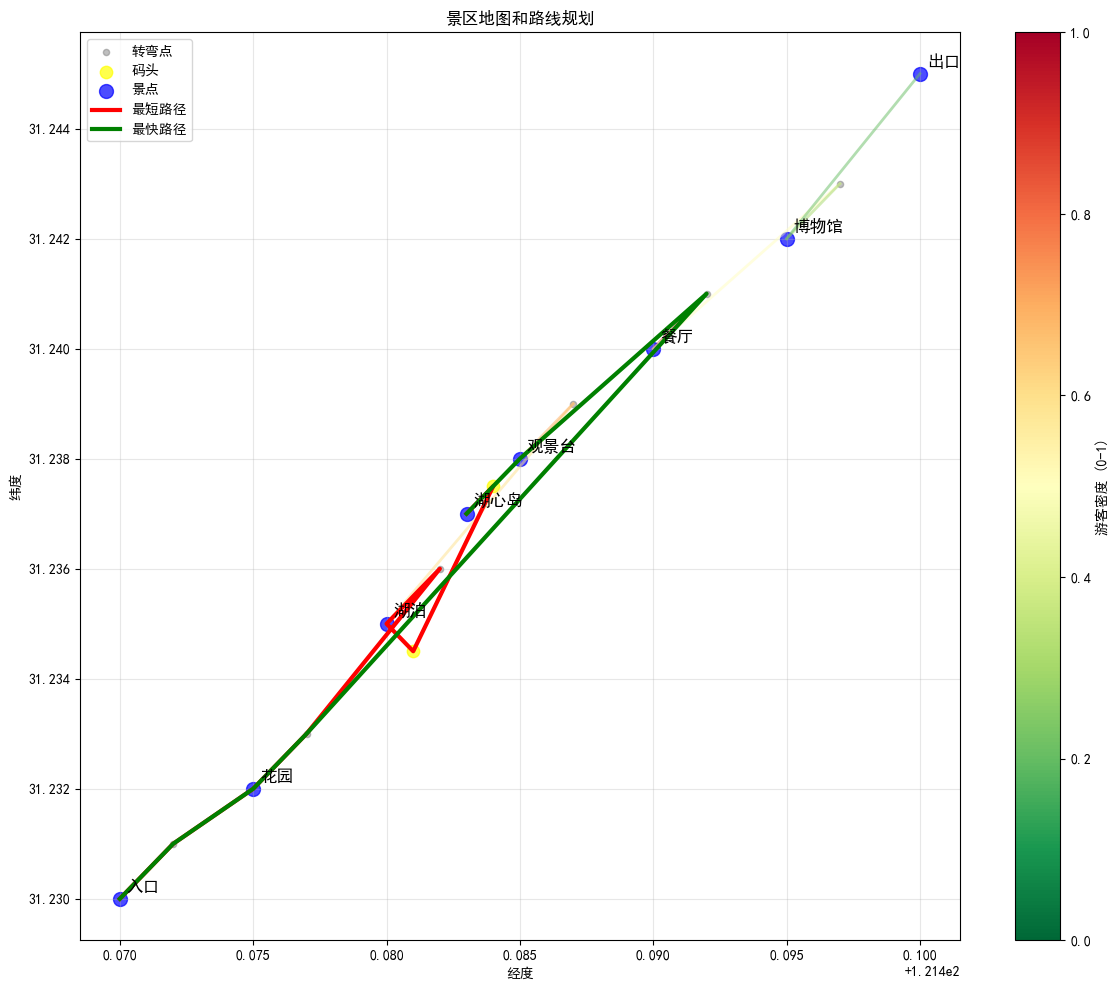


--- 出发时间: 09:15:00 ---
路径找到! 总时间: 2759.30秒
游船信息:
  乘坐游船通过道路 B4 (湖心岛-观景台), 发船时间: 10:00:00
路径详情:
  入口 (景点) -> T1 (转弯点): 153.61秒 (密度: 0.10, 速度: 1.30米/秒)
  T1 (转弯点) -> 花园 (景点): 135.62秒 (密度: 0.30, 速度: 1.11米/秒)
  花园 (景点) -> T2 (转弯点): 109.89秒 (密度: 0.50, 速度: 0.91米/秒)
  T2 (转弯点) -> T5 (转弯点): 297.62秒 (密度: 0.40, 速度: 1.01米/秒)
  T5 (转弯点) -> 观景台 (景点): 211.04秒 (密度: 0.80, 速度: 0.62米/秒)
  观景台 (景点) -> 湖心岛 (景点): 乘船 300.00米 (船速: 5.00米/秒)


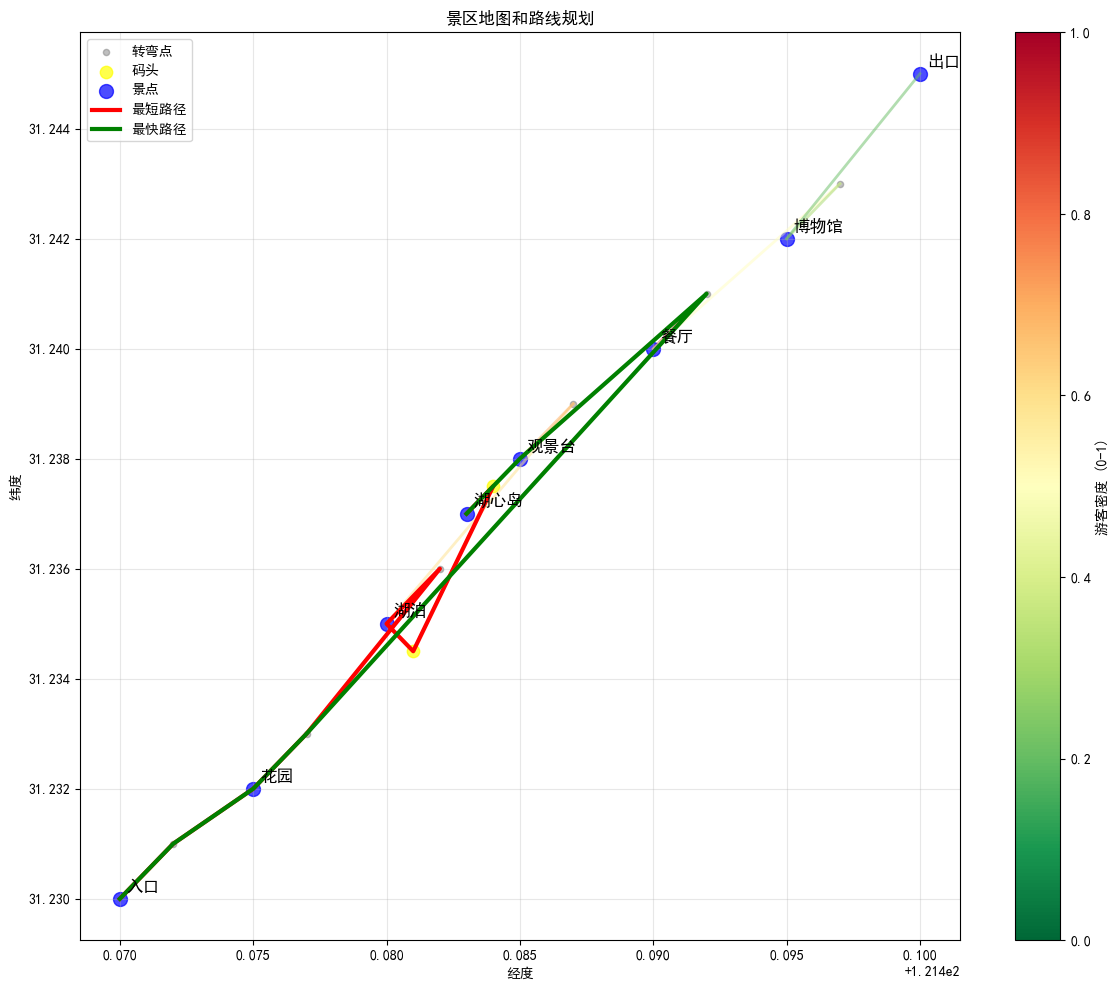


--- 出发时间: 16:30:00 ---
无法找到路径


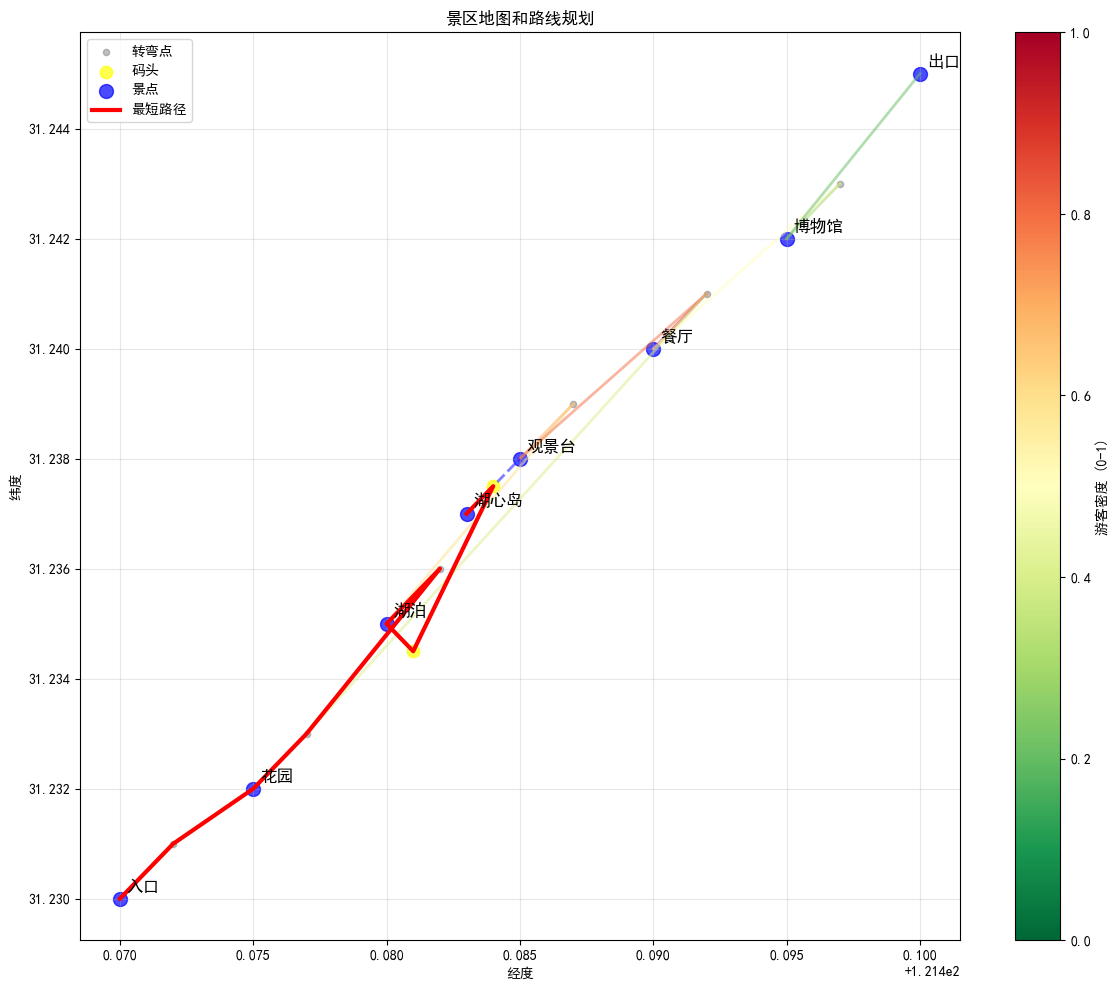

In [61]:
if __name__ == "__main__":
    main()